In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/README.txt
/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/1569_jpg.rf.dc675613d5fce07e505cba269b91fffb.jpg
/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/1345_jpg.rf.54fa804d2c5aa5ee150120987469bc56.jpg
/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/2578_jpg.rf.d050cac989e96e1beb221b4b22b93e82.jpg
/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/1097_jpg.rf.df6c35b4ed24ef8c28138939567ef7ab.jpg
/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/2145_jpg.rf.04fd7a826343eea802b676b730f12ae3.jpg
/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/2061_jpg.rf.d04d5d6171939764f6e239a960e95e02.jpg
/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/2776_jpg.rf.b87922fb0539b4565c732d8cc107507b.jpg
/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/2001_jpg.rf.1e0b2ddfc86e0023d5937a105ab2

In [2]:
import json 
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import numpy as np
import random 
import torch
from torchvision import datasets
from torch.utils.data import Dataset ,DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.optim import lr_scheduler

In [3]:
with open('/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/_annotations.coco.json','r') as file:
    data = json.load(file)

for img in data['images'][:10]:
    print(img['file_name'])

1997_jpg.rf.57e306420710246d04c0d5c26e6496c6.jpg
2422_jpg.rf.59a35b6d8d2eed150af8535cf09bbde5.jpg
1630_jpg.rf.5afc6e25d7987503a11bcb0791b60b53.jpg
1330_jpg.rf.5b23bf18a29b0f50e376b19a5a84f823.jpg
2768_jpg.rf.5b87c0023909e0789a33185a3aab92e9.jpg
2647_jpg.rf.5ba404374f2d670f04a2d1367c77c039.jpg
1511_jpg.rf.5c02bb67a267960293c9e8393c2d9380.jpg
1018_jpg.rf.5c6fcb4480745ff7c60c7305781913ab.jpg
1694_jpg.rf.5c8d647ce366cbd41426af5217863bd4.jpg
2824_jpg.rf.5ca7452639b345dfd0206a58531b6910.jpg


In [4]:
data['categories']

[{'id': 0, 'name': 'Tumor', 'supercategory': 'none'},
 {'id': 1, 'name': '0', 'supercategory': 'Tumor'},
 {'id': 2, 'name': '1', 'supercategory': 'Tumor'}]

In [5]:
def print_structure (d, indent=0):
    if isinstance(d,dict):
        for key , value in d.items():
            print(' ' * indent + str(key))
            print_structure(value,indent+1)
    elif isinstance(d, list):
        print(' ' * indent + "list of length {} containing : ".format(len(d)))
        if d:
            print_structure(d[0],indent+1) # only print the structure of the first item

with open('/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/_annotations.coco.json','r') as file:
    data = json.load(file)

In [6]:
print_structure(data)


info
 year
 version
 description
 contributor
 url
 date_created
licenses
 list of length 1 containing : 
  id
  url
  name
categories
 list of length 3 containing : 
  id
  name
  supercategory
images
 list of length 429 containing : 
  id
  license
  file_name
  height
  width
  date_captured
annotations
 list of length 429 containing : 
  id
  image_id
  category_id
  bbox
   list of length 4 containing : 
  area
  segmentation
   list of length 1 containing : 
    list of length 10 containing : 
  iscrowd


In [7]:
def display_masks(image_names, data):
    fig , ax = plt.subplots(2,2,figsize = (15,15))
    for i, img_path in enumerate(image_names):
        draw_image = cv2.imread(img_path)
        img_filename = os.path.basename(img_path)
        img_id = [item for item in data['images'] if item['file_name'] == img_filename][0]['id']
        img_annotations = [ann for ann in data['annotations'] if ann['image_id'] == img_id]
        points_list = img_annotations[0]['segmentation']
        points = np.array(points_list, np.int32)
        points = points.reshape((-1,1,2))
        # Draw polygon
        cv2.polylines(draw_image,[points],True,(0,0,255),3)
        
        # Display the image
        ax[i//2, i%2].imshow(cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB))
        ax[i//2, i%2].axis('off')
    plt.show()

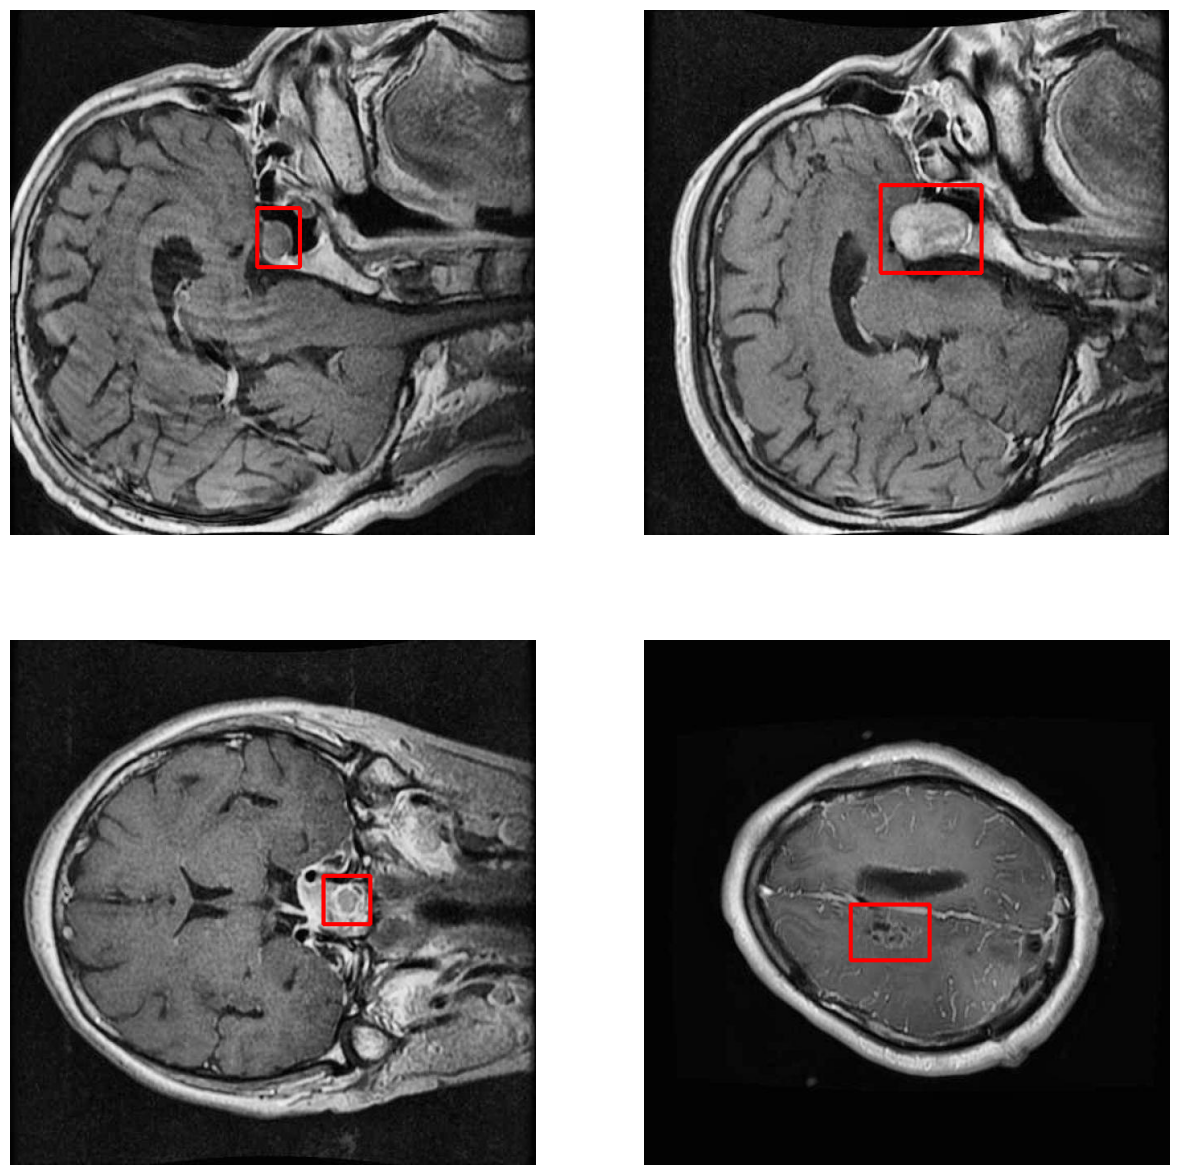

In [8]:
with open('/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/_annotations.coco.json','r') as file:
    annotations = json.load(file)
imge_dir = "/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid"
all_image_files = [os.path.join(imge_dir,img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files,4)
display_masks(random_image_files,annotations)

In [9]:
import json
import numpy as np
import skimage.draw
import tifffile
import os
import shutil
import matplotlib.pyplot as plt

def create_mask(image_info, annotations, output_folder, max_print=3):
    mask_np = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
    object_number = 1
    printed_masks = 0  
    for ann in annotations:
        if ann['image_id'] == image_info['id']:
            for seg_idx, seg in enumerate(ann['segmentation']):
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                seg_mask = np.zeros_like(mask_np, dtype=np.uint8)
                seg_mask[rr, cc] = 255  
                mask_path = os.path.join(output_folder, f"{image_info['file_name'].replace('.jpg', '')}_seg_{seg_idx}.tif")
                tifffile.imwrite(mask_path, seg_mask)
                printed_masks += 1
                if printed_masks >= max_print:
                    return  

In [10]:
def main(json_file, mask_output_folder, image_output_folder, original_image_dir):
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']

    if not os.path.exists(mask_output_folder):
        os.makedirs(mask_output_folder)
    if not os.path.exists(image_output_folder):
        os.makedirs(image_output_folder)

    for img in images:
        create_mask(img, annotations, mask_output_folder)
        original_image_path = os.path.join(original_image_dir, img['file_name'])
        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))
        shutil.copy2(original_image_path, new_image_path)

In [11]:
original_image_dir = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test'  
json_file = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test/_annotations.coco.json'
mask_output_folder = 'test2/masks'  
image_output_folder = 'test2/images'  
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

original_image_dir = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train'  
json_file = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/_annotations.coco.json'
mask_output_folder = 'train2/masks'  
image_output_folder = 'train2/images'  
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

original_image_dir = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid'  
json_file = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/_annotations.coco.json'
mask_output_folder = 'valid2/masks'  
image_output_folder = 'valid2/images'  
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

In [12]:
import os

def compare_folders_and_delete(folder1_path, folder2_path):
    folder1_items = os.listdir(folder1_path)
    folder2_items = os.listdir(folder2_path)

    for item1 in folder1_items:
        found = False
        for item2 in folder2_items:
            if item1[:4] == item2[:4]:
                found = True
                break
        if not found:
            print(f"Corresponding item for {item1} not found.")
            item1_path = os.path.join(folder1_path, item1)
            os.remove(item1_path)
            print(f"Deleted {item1}")

    for item2 in folder2_items:
        found = False
        for item1 in folder1_items:
            if item2[:4] == item1[:4]:
                found = True
                break
        if not found:
            print(f"Corresponding item for {item2} not found.")
            item2_path = os.path.join(folder2_path, item2)
            os.remove(item2_path)
            print(f"Deleted {item2}")

folder1_path = "/kaggle/working/train2/images"
folder2_path = "/kaggle/working/train2/masks"
compare_folders_and_delete(folder1_path, folder2_path)

Corresponding item for 2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg not found.
Deleted 2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg


In [13]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset_general(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        image_gray = image.convert("L") 
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image_gray = self.transform(image_gray)
            mask = self.transform(mask)

        return image_gray, mask

train_path = "/kaggle/working/train2" 
valid_path = "/kaggle/working/valid2"
test_path = "/kaggle/working/test2"

image_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

train_dataset = CustomDataset_general(train_path, transform=image_transform)
valid_dataset = CustomDataset_general(valid_path, transform=image_transform)
test_dataset = CustomDataset_general(test_path, transform=image_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
x, y = next(iter(train_loader))
x.shape , y.shape , type(x) , type(y)

(torch.Size([32, 1, 224, 224]),
 torch.Size([32, 1, 224, 224]),
 torch.Tensor,
 torch.Tensor)

In [15]:
! pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 971.7 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.9 MB/s eta 0:00:00:00:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=2a03354192c010ed0382afc5f97d9c23daa3e04a8d153a67547d1c2a24084399
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=c0b665a3f6546fdf1a2af1e0f44c8eac181a3ad3fdbe564639212e85ae8294f8
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built e

In [16]:
import segmentation_models_pytorch as smp


ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=1, 
    classes=1, 
    activation=ACTIVATION,
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s] 


In [17]:
def train_one_epoch(dataloader , model,loss_fn ,optimizer):
    batch_size = 32
    model.train()
    track_loss = 0
    num_correct = 0
    for i ,(image,labels) in enumerate(dataloader):
        imgs  = image.to(DEVICE)
        labels = labels.to(DEVICE)
        pred = model(imgs)
        loss = loss_fn(pred , labels)
        track_loss+=loss.item()
        num_correct+=(torch.argmax(pred,dim=1)==labels).type(torch.float).sum().item()
        running_loss = round(track_loss/(i+(imgs.shape[0]/batch_size)),2)
        running_acc = round((num_correct/((i*batch_size+imgs.shape[0])))*100,2)
        
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if i%100==0:
            print("Batch:", i+1, "/",len(dataloader), "Running Loss:",running_loss, "Running Accuracy:",running_acc)
            
    epoch_loss=running_loss
    epoch_acc=running_acc
    return epoch_loss, epoch_acc

In [18]:

model=model.to(DEVICE)
loss_fn= nn.BCEWithLogitsLoss()
lr=0.0001
optimizer=torch.optim.Adam(params=model.parameters(), lr=lr)
n_epochs = 10

for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_acc=train_one_epoch(train_loader,model,loss_fn,optimizer)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("--------------------------------------------------")

Epoch No: 1
Batch: 1 / 47 Running Loss: 0.67 Running Accuracy: 154581600.0
Training: Epoch Loss: 0.48 Epoch Accuracy: 154384264.89
--------------------------------------------------
Epoch No: 2
Batch: 1 / 47 Running Loss: 0.35 Running Accuracy: 153069400.0
Training: Epoch Loss: 0.31 Epoch Accuracy: 154383347.1
--------------------------------------------------
Epoch No: 3
Batch: 1 / 47 Running Loss: 0.27 Running Accuracy: 153620100.0
Training: Epoch Loss: 0.25 Epoch Accuracy: 154384060.23
--------------------------------------------------
Epoch No: 4
Batch: 1 / 47 Running Loss: 0.23 Running Accuracy: 156095100.0
Training: Epoch Loss: 0.21 Epoch Accuracy: 154383467.02
--------------------------------------------------
Epoch No: 5
Batch: 1 / 47 Running Loss: 0.19 Running Accuracy: 154141300.0
Training: Epoch Loss: 0.17 Epoch Accuracy: 154385317.26
--------------------------------------------------
Epoch No: 6
Batch: 1 / 47 Running Loss: 0.16 Running Accuracy: 154530400.0
Training: Epoch 

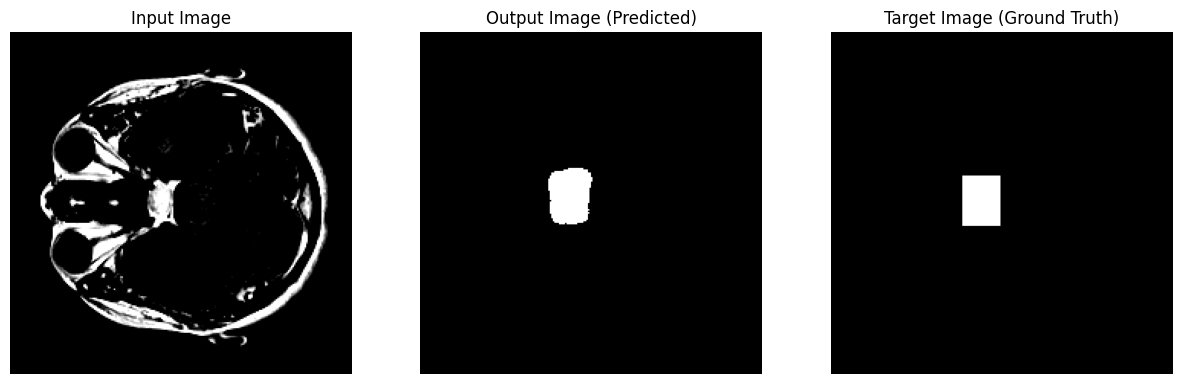

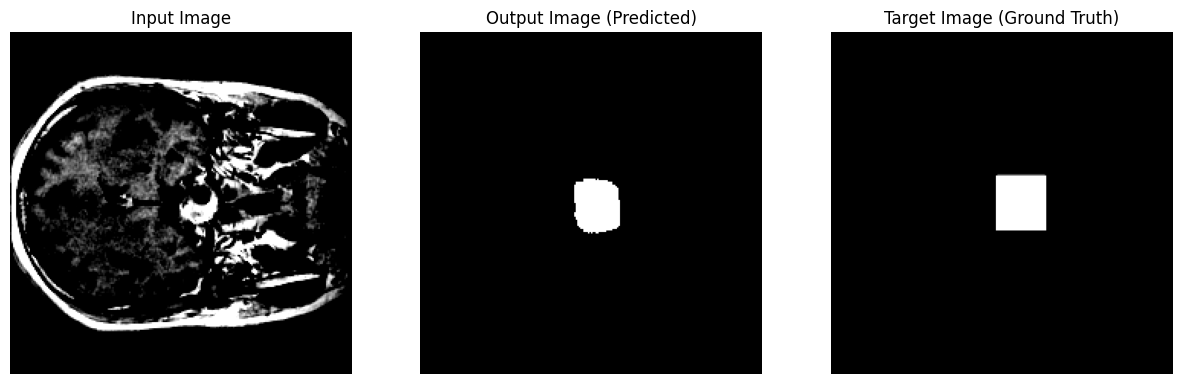

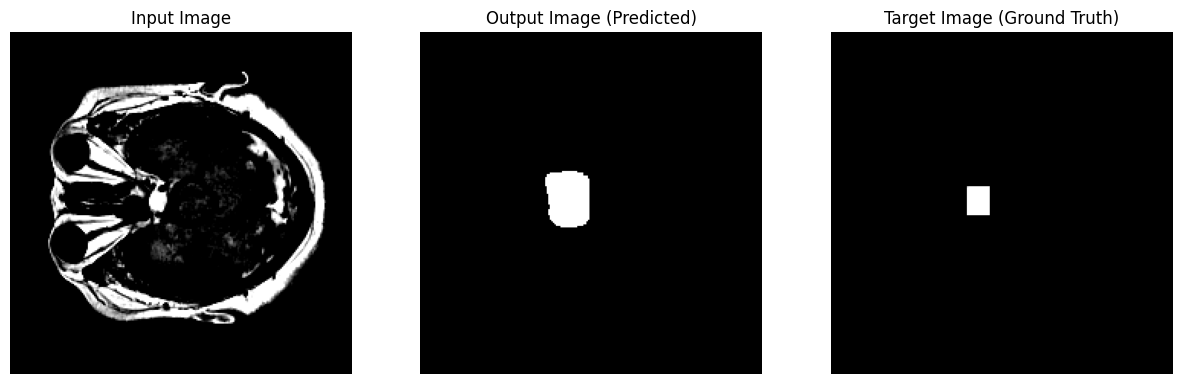

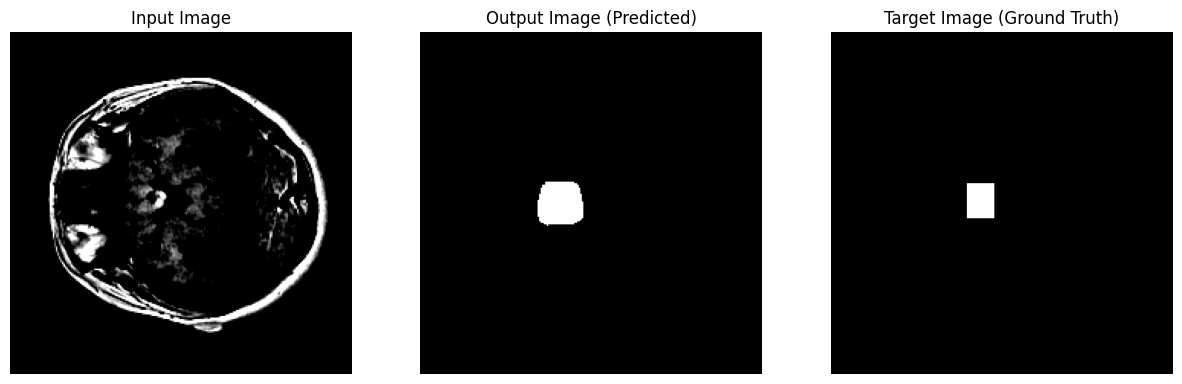

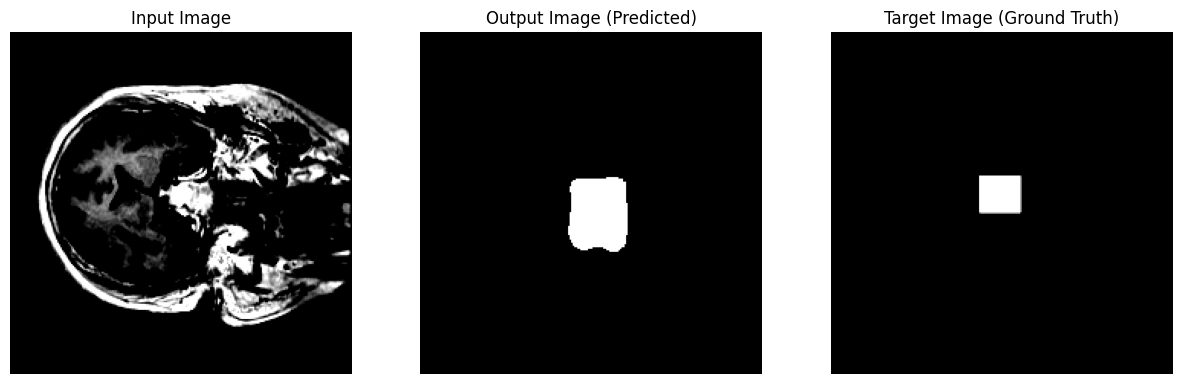

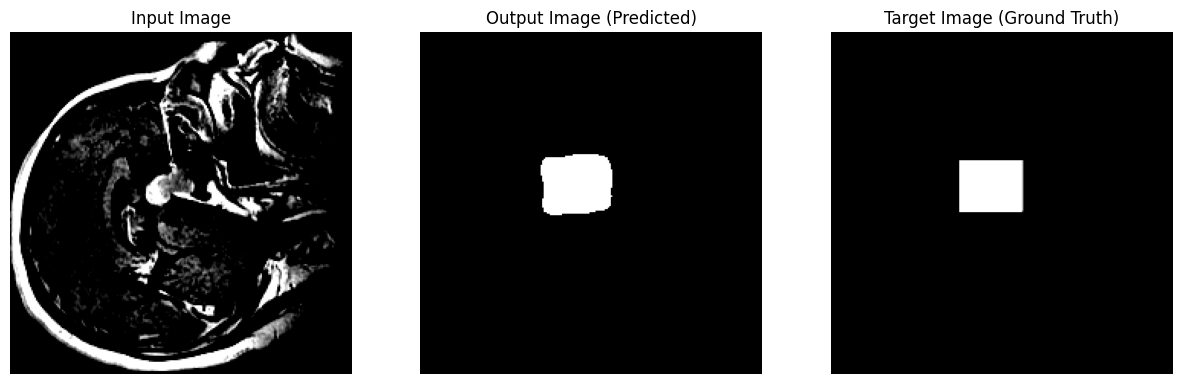

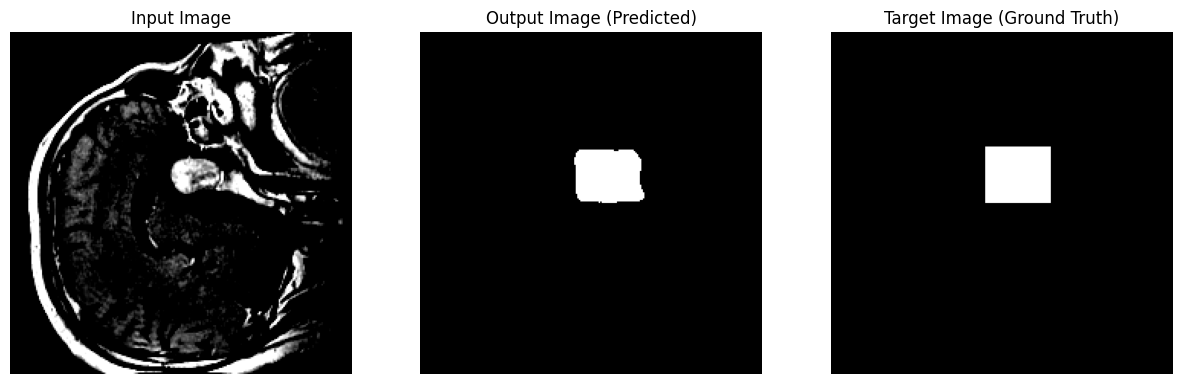

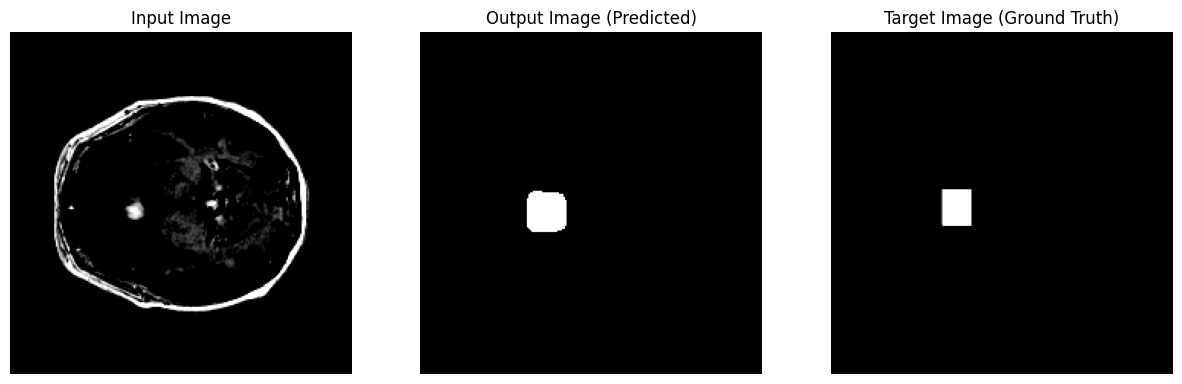

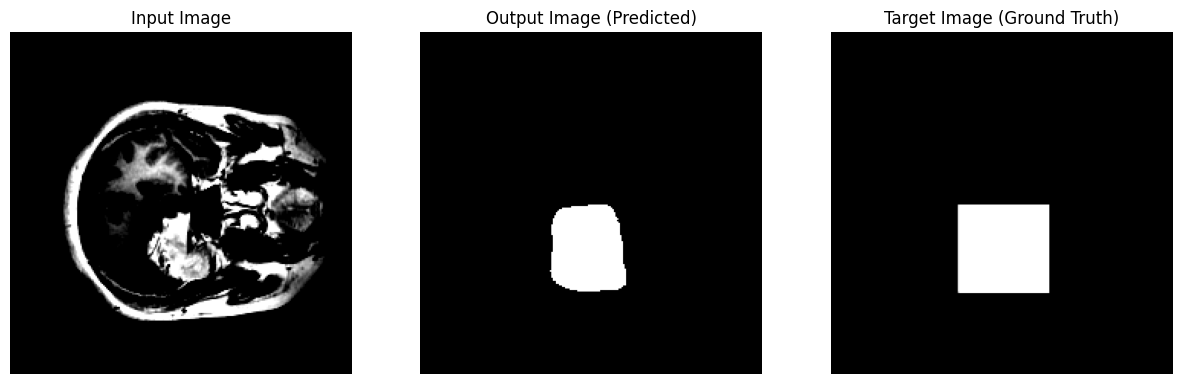

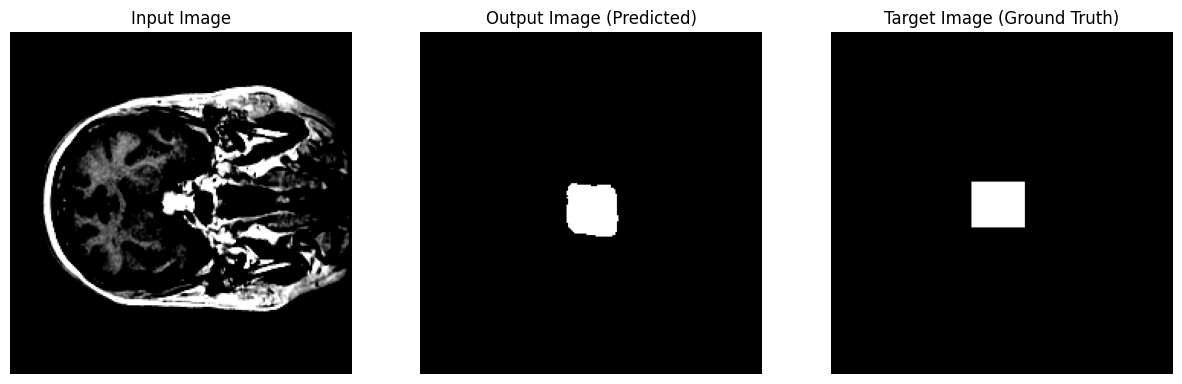

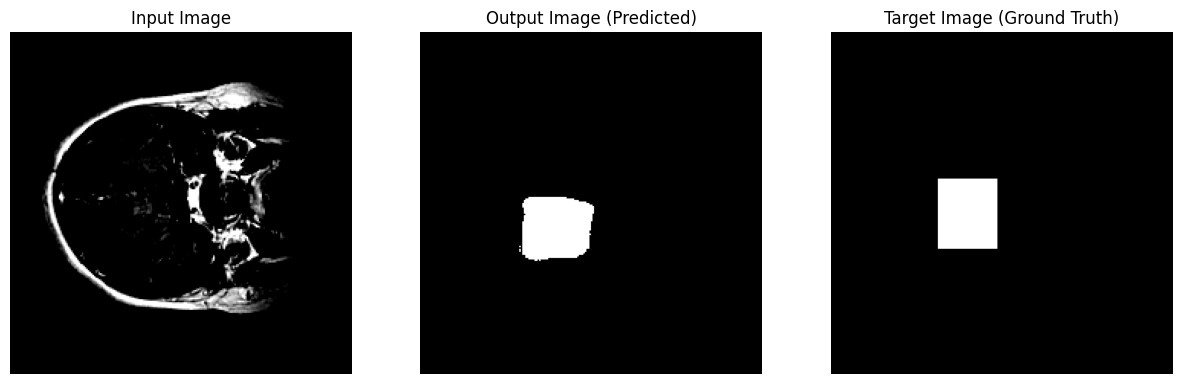

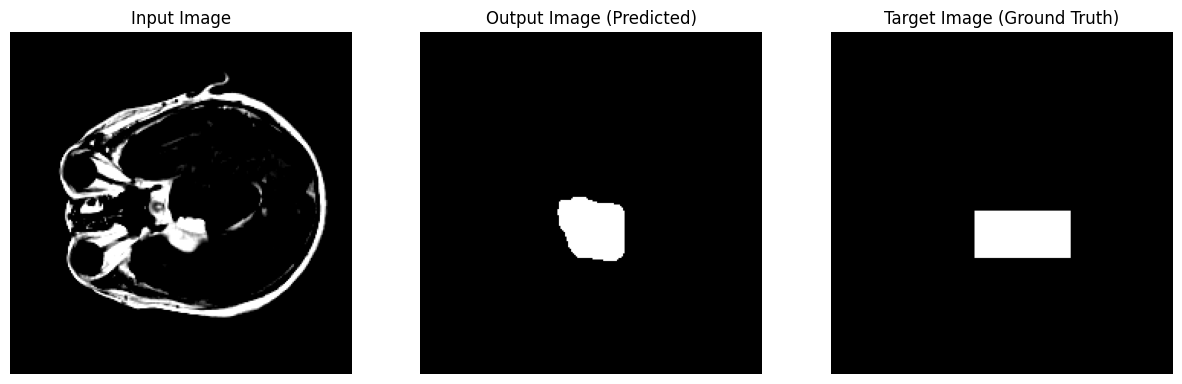

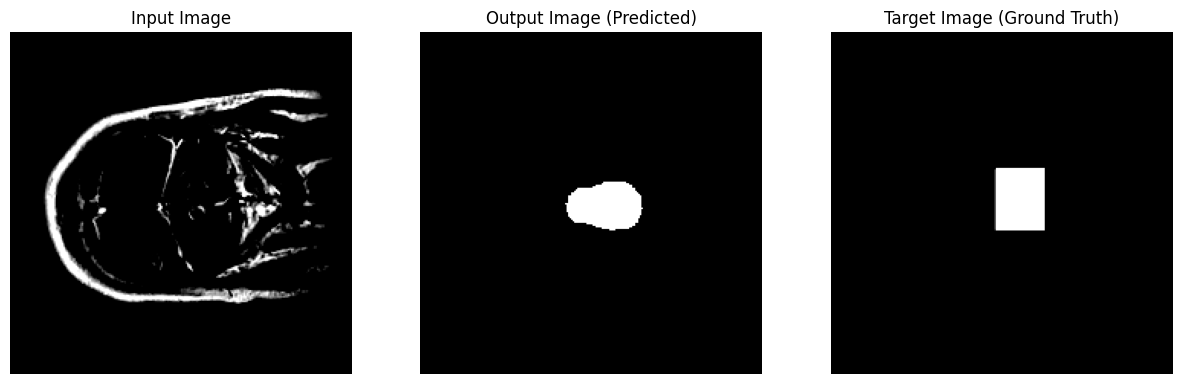

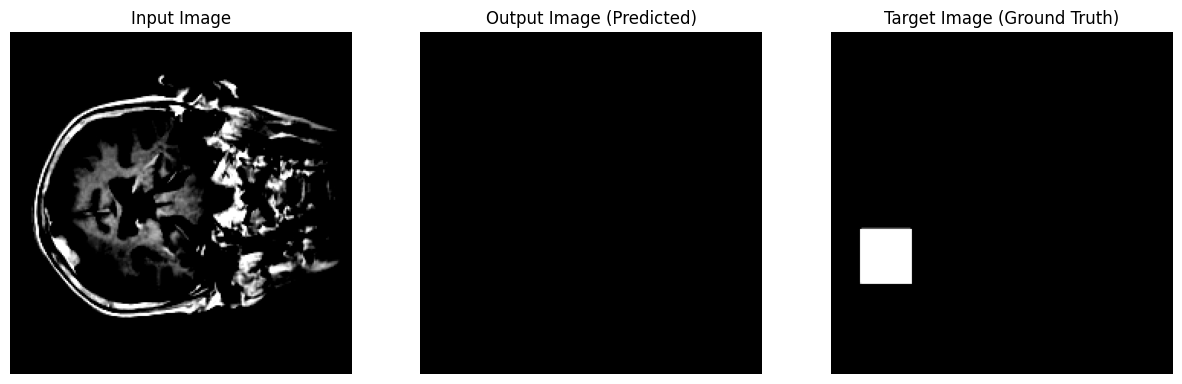

In [19]:
import matplotlib.pyplot as plt

def visualize_input_output_target(input_image, output_image, target_image):
    input_image = input_image.cpu()
    output_image = output_image.cpu()
    target_image = target_image.cpu()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(input_image.squeeze().numpy(), cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(output_image.squeeze().numpy(), cmap='gray')
    axes[1].set_title('Output Image (Predicted)')
    axes[1].axis('off')

    axes[2].imshow(target_image.squeeze().numpy(), cmap='gray')
    axes[2].set_title('Target Image (Ground Truth)')
    axes[2].axis('off')

    plt.show()
    fig.savefig("output.png")

with torch.inference_mode():
    for batch, (X, y) in enumerate(valid_loader):
        X = X.to(DEVICE, dtype=torch.float32)
        y = y.to(DEVICE, dtype=torch.float32)
        y_pred_logits = model(X)
        y_pred_binary = (y_pred_logits > 0.5).float()
        visualize_input_output_target(X[0], y_pred_binary[0], y[0])